# Machine Learning 2 - Final Project

## Learning Team 8 - MSDS PT2025B

* Borromeo, Chloe
* Sison, Florence
* Young, Daniel O.
* Dorado, Joshua Renzo

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = (8,6)

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## A. PREPROCESSING

In [3]:
# Read the Credit Card Balances data

credit_card = (
    pd.read_csv("./data/credit_card_balance.csv")
    # Keep only active contracts and with credit limit for upselling
    .query('NAME_CONTRACT_STATUS == "Active"')
    .sort_values(by=['SK_ID_CURR', 'MONTHS_BALANCE'], ascending=[False, False])
    .drop("NAME_CONTRACT_STATUS", axis=1)
    .set_index('SK_ID_CURR', drop=True)
)

credit_card["AMT_INST_MIN_REGULARITY"] = credit_card["AMT_INST_MIN_REGULARITY"].fillna(0)

credit_card.head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
456250,1794451,-1,153832.725,175500,0.0,0.0,0.0,0.0,8286.390,9675.0,...,151808.220,153832.725,153832.725,0.0,0,0.0,0.0,10.0,0,0
456250,1794451,-2,158266.935,175500,0.0,0.0,0.0,0.0,8477.730,9675.0,...,156053.160,158266.935,158266.935,0.0,0,0.0,0.0,9.0,0,0
456250,1794451,-3,162425.565,175500,0.0,0.0,0.0,0.0,8643.600,9000.0,...,160554.375,162425.565,162425.565,0.0,0,0.0,0.0,8.0,0,0
456250,1794451,-4,166188.150,180000,0.0,0.0,0.0,0.0,8804.565,9000.0,...,163871.775,166188.150,166188.150,0.0,0,0.0,0.0,7.0,0,0
456250,1794451,-5,169443.855,180000,0.0,0.0,0.0,0.0,8931.420,9000.0,...,167091.345,169443.855,169443.855,0.0,0,0.0,0.0,6.0,0,0


In [4]:
print(credit_card.columns)

Index(['SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object')


#### A.1. Add new features to the data

With the help of some domain knowledge, we decided to engineer the following features here. 

In [5]:
# Monthly utilization
credit_card["Monthly_Utilization"] = credit_card["AMT_BALANCE"] / \
    credit_card["AMT_CREDIT_LIMIT_ACTUAL"]

# Tag if the customer paid in full
credit_card["Fully_Paid"] = (credit_card["AMT_BALANCE"] == 0)

# Ratio of the payment with the minimum payment
credit_card["Payment_MinPayment_Ratio"] = (
    credit_card['AMT_PAYMENT_TOTAL_CURRENT'] / credit_card['AMT_INST_MIN_REGULARITY']).fillna(0)

# Indicator if a client only paid the minimum amount
credit_card['Paid_Minimum_Only'] = (credit_card['AMT_INST_MIN_REGULARITY'] ==
                                    credit_card['AMT_PAYMENT_TOTAL_CURRENT']) & (credit_card['AMT_INST_MIN_REGULARITY'] > 0)

# Ratio of drawings from 'Other', 'ATM', 'POS' with Total Current Drawings in terms of transaction values
credit_card['AMT_Other_Ratio'] = (credit_card['AMT_DRAWINGS_OTHER_CURRENT'] /
                                  credit_card['AMT_DRAWINGS_CURRENT']).fillna(0)  # Drawings from Other Channels Ratio
credit_card['AMT_ATM_Ratio'] = (credit_card['AMT_DRAWINGS_ATM_CURRENT'] /
                                credit_card['AMT_DRAWINGS_CURRENT']).fillna(0)  # Drawings from ATM Ratio
credit_card['AMT_POS_Ratio'] = (credit_card['AMT_DRAWINGS_POS_CURRENT'] /
                                credit_card['AMT_DRAWINGS_CURRENT']).fillna(0)  # Drawings or usage using POS Terminals

# Ratio of drawings from 'Other', 'ATM', 'POS' with Total Current Drawings in terms of counts

# Count of drawings from Other Channels Ratio
credit_card['CNT_Other_Ratio'] = (
    credit_card['CNT_DRAWINGS_OTHER_CURRENT'] / credit_card['CNT_DRAWINGS_CURRENT']).fillna(0)
credit_card['CNT_ATM_Ratio'] = (credit_card['CNT_DRAWINGS_ATM_CURRENT'] /
                                credit_card['CNT_DRAWINGS_CURRENT']).fillna(0)  # Count of drawings from ATM Ratio

# Count of drawings or usage using POS Terminals
credit_card['CNT_POS_Ratio'] = (
    credit_card['CNT_DRAWINGS_POS_CURRENT'] / credit_card['CNT_DRAWINGS_CURRENT']).fillna(0)

#### A.2. Client-Level Aggregations

In [6]:
# Get the latest credit limit 
latest_credit_limits = (
    credit_card
    .sort_values(['MONTHS_BALANCE'])
    .groupby('SK_ID_CURR')
    .last()["AMT_CREDIT_LIMIT_ACTUAL"]
)

# Apply the aggregations
agg_functions = {
    'MONTHS_BALANCE': ['count'],
    'AMT_BALANCE': ['mean'],
    'Monthly_Utilization': ['mean', 'max'],
    'Fully_Paid': ['mean', 'sum'],
    'Paid_Minimum_Only': ['mean', 'sum'],
    'Payment_MinPayment_Ratio': ['mean'],
    'AMT_Other_Ratio': ['mean'],
    'AMT_ATM_Ratio': ['mean'],
    'AMT_POS_Ratio': ['mean'],
    'CNT_Other_Ratio': ['mean'],
    'CNT_ATM_Ratio': ['mean'],
    'CNT_POS_Ratio': ['mean']
}

credit_card_agg = (
    credit_card
    .groupby("SK_ID_CURR")
    .agg(agg_functions)
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)

# Rename columns
credit_card_agg.columns = [f'{col[0]}_{col[1]}' for col in credit_card_agg.columns]
credit_card_agg = credit_card_agg.rename(columns={
    'MONTHS_BALANCE_count': 'Tenure_Months', 
    'AMT_BALANCE_mean': 'Avg_Monthly_Balance',
    'Monthly_Utilization_mean': 'Avg_Monthly_Utilization',
    'Monthly_Utilization_max': 'Max_Monthly_Utilization',
    'Fully_Paid_mean': 'Pct_Txns_Fully_Paid',
    'Fully_Paid_sum': 'Months_Fully_Paid',
    'Paid_Minimum_Only_mean': 'Pct_Txns_Minimum_Paid',
    'Paid_Minimum_Only_sum': 'Months_Minimum_Paid',
    'AMT_Other_Ratio_mean': 'Avg_AMT_Other_Ratio',
    'AMT_ATM_Ratio_mean': 'Avg_AMT_ATM_Ratio',
    'AMT_POS_Ratio_mean': 'Avg_AMT_POS_Ratio',
    'CNT_Other_Ratio_mean': 'Avg_CNT_Other_Ratio',
    'CNT_ATM_Ratio_mean': 'Avg_CNT_ATM_Ratio',
    'CNT_POS_Ratio_mean': 'Avg_CNT_POS_Ratio'
})

# Incorporate the latest credit limit
credit_card_agg = pd.merge(credit_card_agg, latest_credit_limits,
                           how="inner", 
                           left_index=True, right_index=True)
credit_card_agg.head()


,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,Avg_AMT_Other_Ratio,Avg_AMT_ATM_Ratio,Avg_AMT_POS_Ratio,Avg_CNT_Other_Ratio,Avg_CNT_ATM_Ratio,Avg_CNT_POS_Ratio,AMT_CREDIT_LIMIT_ACTUAL
SK_ID_CURR,,,,,,,,,,,,,,,,
100006,6,0.000000,0.000000,0.00000,1.000000,6,0.000000,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,270000
100011,74,54482.111149,0.302678,1.05000,0.554054,41,0.418919,31,0.502230,0.0,0.013514,0.0,0.0,0.013514,0.0,90000
100013,96,18159.919219,0.115301,1.02489,0.770833,74,0.000000,0,0.865673,0.0,0.052083,0.0,0.0,0.052083,0.0,45000
100021,7,0.000000,0.000000,0.00000,1.000000,7,0.000000,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,675000
100023,8,0.000000,0.000000,0.00000,1.000000,8,0.000000,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,225000


#### A.3. Merge with client-level information (e.g. Demographics and Properties Information)

In [7]:
# Read customer-related data

customer_1 = pd.read_csv("./data/application_train.csv")
customer_2 = pd.read_csv("./data/application_test.csv")

# Concatenate the DataFrames and include all specified columns
customer_info = (
    pd.concat([customer_1, customer_2], axis=0)
    # .set_index("SK_ID_CURR")
    .sort_index()
    [['SK_ID_CURR',  # Customer ID
      'TARGET',  # Tag with late payment
      'CODE_GENDER',  # Gender
      'FLAG_OWN_CAR',  # Owns a car
      'FLAG_OWN_REALTY',  # Owns real property
      'CNT_CHILDREN',  # Number of children
      'AMT_INCOME_TOTAL',  # Total income
      'NAME_INCOME_TYPE',  # Income type
      'NAME_EDUCATION_TYPE',  # Education type
      'NAME_FAMILY_STATUS',  # Family status
      'NAME_HOUSING_TYPE',  # Housing type
      'DAYS_BIRTH',  # Age
      'DAYS_EMPLOYED',  # Employment duration in days
      'OWN_CAR_AGE',  # Age of the car
      'OCCUPATION_TYPE',  # Occupation type
      'CNT_FAM_MEMBERS',  # Number of family members
      'EXT_SOURCE_1',  # External source 1
      'EXT_SOURCE_2',  # External source 2
      'EXT_SOURCE_3'  # External source 3
      ]]
)

# Rename column 'TARGET' with 'W_DEFAULT'
customer_info.rename(columns={'TARGET': 'W_DEFAULT'}, inplace=True)

customer_info.head()  


,SK_ID_CURR,W_DEFAULT,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1.0,M,N,Y,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,NaN,Laborers,1.0,0.083037,0.262949,0.139376
0,100001,NaN,F,N,Y,0,135000.0,Working,Higher education,Married,House / apartment,-19241,-2329,NaN,NaN,2.0,0.752614,0.789654,0.159520
1,100005,NaN,M,N,Y,0,99000.0,Working,Secondary / secondary special,Married,House / apartment,-18064,-4469,NaN,Low-skill Laborers,2.0,0.564990,0.291656,0.432962
1,100003,0.0,F,N,N,0,270000.0,State servant,Higher education,Married,House / apartment,-16765,-1188,NaN,Core staff,2.0,0.311267,0.622246,NaN
2,100004,0.0,M,Y,Y,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,26.0,Laborers,1.0,NaN,0.555912,0.729567


In [8]:
# Join Credit Card data and Customer Information Dataframes

df_joined = pd.merge(credit_card_agg, customer_info, how="left", on='SK_ID_CURR')

# Express customer age in years
df_joined["Age_Years"] = abs(df_joined["DAYS_BIRTH"]) / 365

# Express customer age in years
df_joined["Employed_Months"] = abs(df_joined["DAYS_EMPLOYED"]) / 30

# Gender indicator
df_joined["CODE_GENDER_M"] = df_joined['CODE_GENDER'].map({'F': 0, 'M': 1})

# Indicator if client owns a car
df_joined["FLAG_OWN_CAR"] = df_joined['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})

# Indicator if client owns a real property
df_joined["FLAG_OWN_REALTY"] = df_joined['FLAG_OWN_REALTY'].map({
                                                                'Y': 1, 'N': 0})

# Drop redundant columns
df_joined = df_joined.drop(['CODE_GENDER', 'DAYS_BIRTH'], axis=1)

# Drop rows with no value on any EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
external_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df_joined = df_joined[~df_joined[external_sources].isna().all(
    axis=1)]  # Only one row has none of all

# Create new columns to reflect best and worst scores from EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE3
df_joined['EXT_SOURCE_best'] = df_joined[external_sources].apply(
    lambda row: row.max(skipna=True), axis=1)
df_joined['EXT_SOURCE_worst'] = df_joined[external_sources].apply(
    lambda row: row.min(skipna=True), axis=1)

# Isolate columns EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_joined = df_joined.drop(columns=external_sources)

# Drop rows with 0 'AMT_CREDIT_LIMIT_ACTUAL' since they cannot be upsold with expanded limit (re-activation would be required instead)
# we do this later
# df_joined = df_joined[df_joined['AMT_CREDIT_LIMIT_ACTUAL'] != 0]

In [9]:
# use mean to fill NA for own car age so that this data can be used without effect for the missing rows
df_joined['OWN_CAR_AGE'].fillna(df_joined.OWN_CAR_AGE.mean(), inplace=True)

# Create new feature credit limit to income ratio
df_joined['credit_limit_income_ratio'] = df_joined['AMT_CREDIT_LIMIT_ACTUAL'] / df_joined['AMT_INCOME_TOTAL']

In [10]:
# na_counts = df_joined['W_DEFAULT'].isna().sum()
# print(f"Number of NA values in W_DEFAULT column: {na_counts}")

df_joined['W_DEFAULT'].fillna(0, inplace=True)
df_joined

,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Age_Years,Employed_Months,CODE_GENDER_M,EXT_SOURCE_best,EXT_SOURCE_worst,credit_limit_income_ratio
0,100006,6,0.000000,0.000000,0.000000,1.000000,6,0.000000,0,0.000000,...,-3039,11.672287,Laborers,2.0,52.068493,101.300000,0,0.650442,0.650442,2.000000
1,100011,74,54482.111149,0.302678,1.050000,0.554054,41,0.418919,31,0.502230,...,365243,11.672287,NaN,2.0,55.065753,12174.766667,0,0.751724,0.205747,0.800000
2,100013,96,18159.919219,0.115301,1.024890,0.770833,74,0.000000,0,0.865673,...,-4458,5.000000,Drivers,2.0,54.898630,148.600000,1,0.699787,0.610991,0.222222
3,100021,7,0.000000,0.000000,0.000000,1.000000,7,0.000000,0,0.000000,...,-191,11.672287,Laborers,3.0,26.783562,6.366667,0,0.683513,0.683513,8.333333
4,100023,8,0.000000,0.000000,0.000000,1.000000,8,0.000000,0,0.000000,...,-2038,11.672287,Core staff,2.0,31.090411,67.933333,0,0.586617,0.477649,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103463,456244,36,150145.110000,0.444874,1.008061,0.527778,19,0.000000,0,0.000000,...,-5326,11.672287,NaN,2.0,55.863014,177.533333,0,0.896042,0.337673,0.000000
103464,456246,8,13136.731875,0.097309,0.322149,0.250000,2,0.000000,0,7.790879,...,-8736,11.672287,Laborers,3.0,44.008219,291.200000,0,0.735221,0.313334,1.428571
103465,456247,95,23216.396211,0.161225,1.056679,0.684211,65,0.105263,10,0.000000,...,-399,11.672287,Core staff,1.0,32.520548,13.300000,0,0.609276,0.243466,0.000000
103466,456248,23,0.000000,0.000000,0.000000,1.000000,23,0.000000,0,0.000000,...,-7258,11.672287,Sales staff,1.0,45.767123,241.933333,0,0.530725,0.530725,5.882353


#### A.4 Merge with installments data

In [11]:
installments_info = (
    pd.read_csv('./data/installments_payments.csv') 
    .sort_values(by=['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER'], ascending=[False, False])
)

In [12]:
installments_info["LATE_PAYMENT"] = installments_info["DAYS_ENTRY_PAYMENT"] < installments_info["DAYS_INSTALMENT"]
installments_info["LATE_PAYMENT"] = installments_info["LATE_PAYMENT"].astype(int)

installments_info["DAYS_LATE"] = installments_info["DAYS_ENTRY_PAYMENT"] - installments_info["DAYS_INSTALMENT"]
installments_info["DAYS_LATE"] = np.abs(np.where(installments_info["DAYS_LATE"] < 0, installments_info["DAYS_LATE"], 0))

installments_info["AMT_LESS"] = np.abs(np.where(installments_info["AMT_PAYMENT"] < installments_info["AMT_INSTALMENT"], installments_info["AMT_PAYMENT"] - installments_info["AMT_INSTALMENT"], 0))

In [13]:
latest_installment = (
  installments_info
  .sort_values(['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER'])
  .groupby('SK_ID_CURR')
  .last()['SK_ID_PREV']
)
latest_installment.head()
agg_functions = {
    'LATE_PAYMENT': ['sum'],
    'AMT_LESS': ['sum', 'max'],
    'DAYS_LATE': ['mean', 'max']
}

installments_agg = (
  installments_info
  .groupby("SK_ID_CURR")
  .agg(agg_functions)
  .fillna(0)
  .replace([np.inf, -np.inf], 0)
)
installments_agg.columns = [f'{col[0]}_{col[1]}' for col in installments_agg.columns]
installments_agg = installments_agg.rename(columns={
    'LATE_PAYMENT_sum': 'LATE_PAYMENT_DAYS', 
    'AMT_LESS_sum': 'AMT_LESS_TOTAL',
    'AMT_LESS_max': 'AMT_LESS_MAX',
    'DAYS_LATE_mean': 'DAYS_LATE_AVG',
    'DAYS_LATE_max': 'DAYS_LATE_MAX',
})
print(installments_agg.columns)

installments_agg = pd.merge(installments_agg, latest_installment,
                           how="inner", 
                           left_index=True, right_index=True)
installments_agg.head()

Index(['LATE_PAYMENT_DAYS', 'AMT_LESS_TOTAL', 'AMT_LESS_MAX', 'DAYS_LATE_AVG',
       'DAYS_LATE_MAX'],
      dtype='object')


,LATE_PAYMENT_DAYS,AMT_LESS_TOTAL,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_ID_PREV
SK_ID_CURR,,,,,,
100001,4,0.0,0.0,8.857143,36.0,1851984
100002,19,0.0,0.0,20.421053,31.0,1038818
100003,25,0.0,0.0,7.160000,14.0,2396755
100004,3,0.0,0.0,7.666667,11.0,1564014
100005,8,0.0,0.0,23.666667,37.0,2495675


In [14]:
df_joined = pd.merge(df_joined, installments_agg, how='inner', 
                     on='SK_ID_CURR')

df_joined.drop(columns=['SK_ID_PREV'], inplace=True, axis=1)

In [15]:
# Check for columns with missing values
na_columns = df_joined.columns[df_joined.isna().any()].tolist()
print("Columns with missing values:", na_columns)

Columns with missing values: ['OCCUPATION_TYPE']


In [16]:
minority_ratio = df_joined['W_DEFAULT'].value_counts()[1] / \
    df_joined['W_DEFAULT'].value_counts()[0]

print(f"Ratio of minority class to majority: {minority_ratio:.2f}")

Ratio of minority class to majority: 0.08


<Axes: xlabel='W_DEFAULT', ylabel='count'>

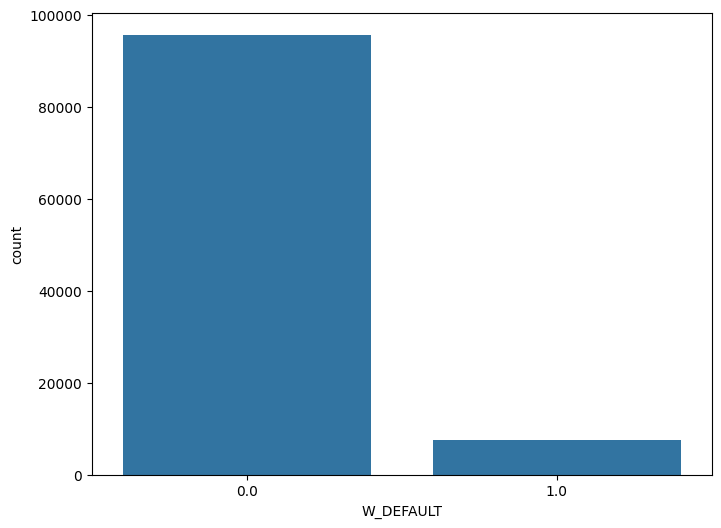

In [17]:
sns.countplot(data = df_joined, x = 'W_DEFAULT')

In [18]:
df_joined.head()

,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,Employed_Months,CODE_GENDER_M,EXT_SOURCE_best,EXT_SOURCE_worst,credit_limit_income_ratio,LATE_PAYMENT_DAYS,AMT_LESS_TOTAL,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX
0,100006,6,0.000000,0.000000,0.00000,1.000000,6,0.000000,0,0.000000,...,101.300000,0,0.650442,0.650442,2.000000,16,0.000,0.000,19.375000,77.0
1,100011,74,54482.111149,0.302678,1.05000,0.554054,41,0.418919,31,0.502230,...,12174.766667,0,0.751724,0.205747,0.800000,64,292086.855,30833.685,4.807692,32.0
2,100013,96,18159.919219,0.115301,1.02489,0.770833,74,0.000000,0,0.865673,...,148.600000,1,0.699787,0.610991,0.222222,49,179437.725,23147.820,5.722581,38.0
3,100021,7,0.000000,0.000000,0.00000,1.000000,7,0.000000,0,0.000000,...,6.366667,0,0.683513,0.683513,8.333333,18,0.000,0.000,14.739130,46.0
4,100023,8,0.000000,0.000000,0.00000,1.000000,8,0.000000,0,0.000000,...,67.933333,0,0.586617,0.477649,2.500000,21,0.000,0.000,15.653846,43.0


In [19]:
# One-hot encode the specified columns
columns_to_encode = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
df_joined = pd.get_dummies(df_joined, columns=columns_to_encode, prefix=columns_to_encode, dtype=int)

df_joined


,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,100006,6,0.000000,0.000000,0.000000,1.000000,6,0.000000,0,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,100011,74,54482.111149,0.302678,1.050000,0.554054,41,0.418919,31,0.502230,...,0,0,0,0,0,0,0,0,0,0
2,100013,96,18159.919219,0.115301,1.024890,0.770833,74,0.000000,0,0.865673,...,0,0,0,0,0,0,0,0,0,0
3,100021,7,0.000000,0.000000,0.000000,1.000000,7,0.000000,0,0.000000,...,1,0,0,0,0,0,0,0,0,0
4,100023,8,0.000000,0.000000,0.000000,1.000000,8,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103192,456244,36,150145.110000,0.444874,1.008061,0.527778,19,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
103193,456246,8,13136.731875,0.097309,0.322149,0.250000,2,0.000000,0,7.790879,...,1,0,0,0,0,0,0,0,0,0
103194,456247,95,23216.396211,0.161225,1.056679,0.684211,65,0.105263,10,0.000000,...,0,0,0,0,0,0,0,0,0,0
103195,456248,23,0.000000,0.000000,0.000000,1.000000,23,0.000000,0,0.000000,...,0,0,0,0,0,0,1,0,0,0


In [20]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split


# Convert non-numeric columns later to flatten
X = df_joined.drop(columns=['W_DEFAULT'])
y = df_joined['W_DEFAULT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

# Combine the resampled features and target variable into a single DataFrame
df_adasyn = pd.concat([X_res, y_res], axis=1)

df_adasyn.head()


,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,W_DEFAULT
0,156827,15,0.000000,0.000000,0.000000,1.000000,15,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0.0
1,431373,62,32027.503065,0.474482,1.060691,0.387097,24,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0.0
2,294195,86,54145.109302,0.601612,1.111306,0.232558,20,0.546512,47,1.327395,...,0,0,0,0,0,0,0,0,0,0.0
3,318608,96,12169.499531,0.262238,0.707680,0.760417,73,0.031250,3,0.000000,...,0,0,0,0,0,0,0,0,0,1.0
4,396433,9,0.000000,0.000000,0.000000,1.000000,9,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0.0


Ratio of minority class to majority: 1.00


Text(0.5, 1.0, 'ADASYN Balanced')

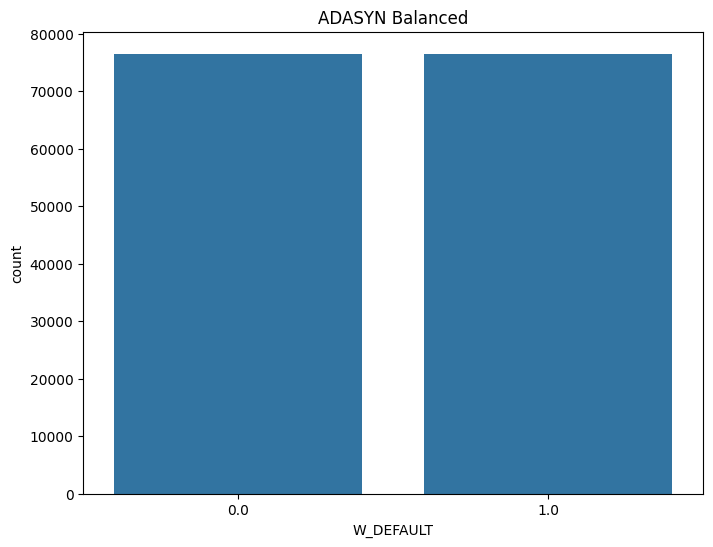

In [22]:
minority_ratio = df_adasyn['W_DEFAULT'].value_counts()[1] / \
    df_adasyn['W_DEFAULT'].value_counts()[0]

print(f"Ratio of minority class to majority: {minority_ratio:.2f}")

sns.countplot(data=df_adasyn, x='W_DEFAULT').set_title('ADASYN Balanced')

In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Combine the resampled features and target variable into a single DataFrame
df_smote = pd.concat([X_res, y_res], axis=1)

df_smote.head()


,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,W_DEFAULT
0,156827,15,0.000000,0.000000,0.000000,1.000000,15,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0.0
1,431373,62,32027.503065,0.474482,1.060691,0.387097,24,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0.0
2,294195,86,54145.109302,0.601612,1.111306,0.232558,20,0.546512,47,1.327395,...,0,0,0,0,0,0,0,0,0,0.0
3,318608,96,12169.499531,0.262238,0.707680,0.760417,73,0.031250,3,0.000000,...,0,0,0,0,0,0,0,0,0,1.0
4,396433,9,0.000000,0.000000,0.000000,1.000000,9,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0.0


Ratio of minority class to majority: 1.00


Text(0.5, 1.0, 'SMOTE Balanced')

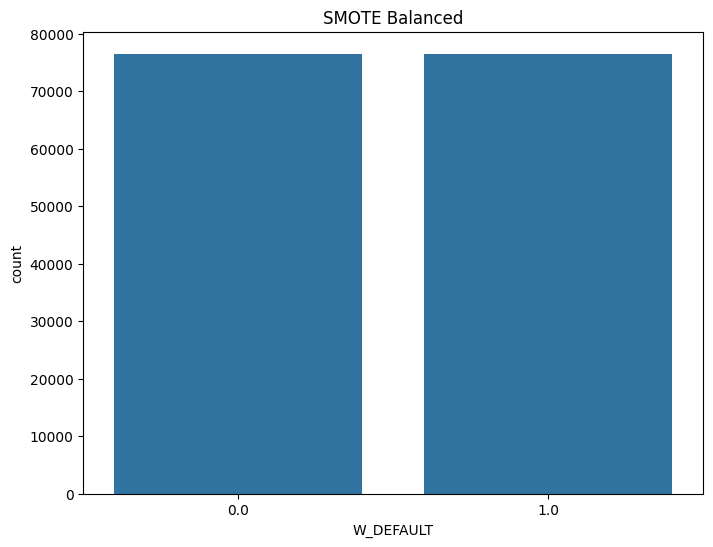

In [24]:
minority_ratio = df_smote['W_DEFAULT'].value_counts()[1] / \
    df_smote['W_DEFAULT'].value_counts()[0]

print(f"Ratio of minority class to majority: {minority_ratio:.2f}")

sns.countplot(data = df_smote, x = 'W_DEFAULT').set_title('SMOTE Balanced')